<a href="https://colab.research.google.com/github/marianfoo/ShopDataML/blob/master/notebooks/Aufgabe_Shopdaten_KNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relevante Bibliotheken importieren

- transact_train   = Transaktionsdaten zum trainieren
- transact_class   = aktuelle Transaktionsdaten zum testen
- realclass_t1     = "Lösung" der transact_class ob Käufer oder nicht

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Methoden für den Import der vorbereiteten Daten

get_test_data: splittet die "order" Spalte von den Test und Trainingsdaten

import_data_colab: liest die daten vom Pfad, setzt Session No als Index und sortiert nach Session No

get_all_data_colab: für jeden fill_modes gibt es vier versch. Anzahl an Spalten, über diese wird iteriert und alle Dateien aus dem GitHub geholt und ein einem Dictionary gespeichert


In [0]:
def get_test_data(train_df,test_df):
    X_train = train_df.iloc[:, :train_df.shape[1] - 1]
    X_test = test_df.iloc[:, :test_df.shape[1] - 1]
    y_train = train_df['order']
    y_test  = test_df['order']
    return X_train, X_test, y_train, y_test
def import_data_colab(path):
    df = pd.read_csv(path)
    df.set_index('sessionNo', inplace=True)
    df.sort_index(inplace=True)
    return df
def get_all_data_colab():
    columns_data = ['X_train_','X_test_','y_train_','y_test_']
    fill_modes = ['mean','mode','median']
    column_count = [5,10,15,20]
    new_dict = {}

    for fill_mode in fill_modes:
        for count in column_count:
            filename_base = 'https://raw.githubusercontent.com/marianfoo/ShopDataML/master/data/'
            filename_2 = filename_base + 'train' + '_' + fill_mode + '_' + str(count) + '.csv'
            train_file = import_data_colab(filename_2)
            filename_2 = filename_base + 'class' + '_' + fill_mode + '_' + str(count) + '.csv'
            class_file = import_data_colab(filename_2)
            X_train, X_test, y_train, y_test = get_test_data(train_file,class_file)
            new_dict[fill_mode + '_' + str(count)] = {
                'X_train':X_train,
                'X_test':X_test,
                'y_train':y_train,
                'y_test':y_test
            }
    return new_dict
def predictionScorekNN(data):
  knn_model = KNeighborsClassifier(n_neighbors=23)
  knn_model.fit(data['X_train'], data['y_train'])
  prediction_knn = knn_model.predict(data['X_test'])
  return knn_model.score(data['X_test'], data['y_test'])*100

# K nearest neighbor

### get all data

rufe die Methode auf um alle Test- und Trainingsdaten zu holen

In [0]:
data_knn = get_all_data_colab()

### group all the data by session number

gruppieren alle Spalten anhand der Session No und nehme immer die höchste Zahl

In [0]:
for key, value in data_knn.items():
  xtrain = value['X_train']
  ytrain = value['y_train']
  xtest = value['X_test']
  ytest = value['y_test']
  value['X_train'] = xtrain.groupby(xtrain.index).max()
  value['y_train'] = ytrain.groupby(ytrain.index).max()
  value['X_test'] = xtest.groupby(xtest.index).max()
  value['y_test'] = ytest.groupby(ytest.index).max()

## Spalten visualisieren

### Daten ggf. runterskalieren

sollte die Berechnung gewisser Vorgänge länger dauern, wäre es möglich mit dieser Methode die Anzahl der Datensätze zu reduzieren

In [0]:
def down_size_data(factor, df):
    print('Shape of dataframe before down sizing with factor' + str(factor) +':' + str(df.shape))
    sampleSize = int(len(df.index) * factor)
    df = df.sample(sampleSize,random_state=0)
    print('Shape of dataframe after down sizing with factor' + str(factor) + ':' + str(df.shape))
    return df

In [6]:
data_median_5_plot_X = data_knn['median_5']['X_train']
data_median_5_plot_y = data_knn['median_5']['y_train']
data_median_5_plot_m = data_median_5_plot_X.merge(data_median_5_plot_y.to_frame(), left_index=True, right_index=True)
data_median_5_plot_m = down_size_data(0.01,data_median_5_plot_m)

Shape of dataframe before down sizing with factor0.01:(50000, 6)
Shape of dataframe after down sizing with factor0.01:(500, 6)


### Pairplot mit order und 5 Spalten

dieser Plot zeigt die Statistiken mit allen fünf Spalten in Bezug auf der "order" Spalte

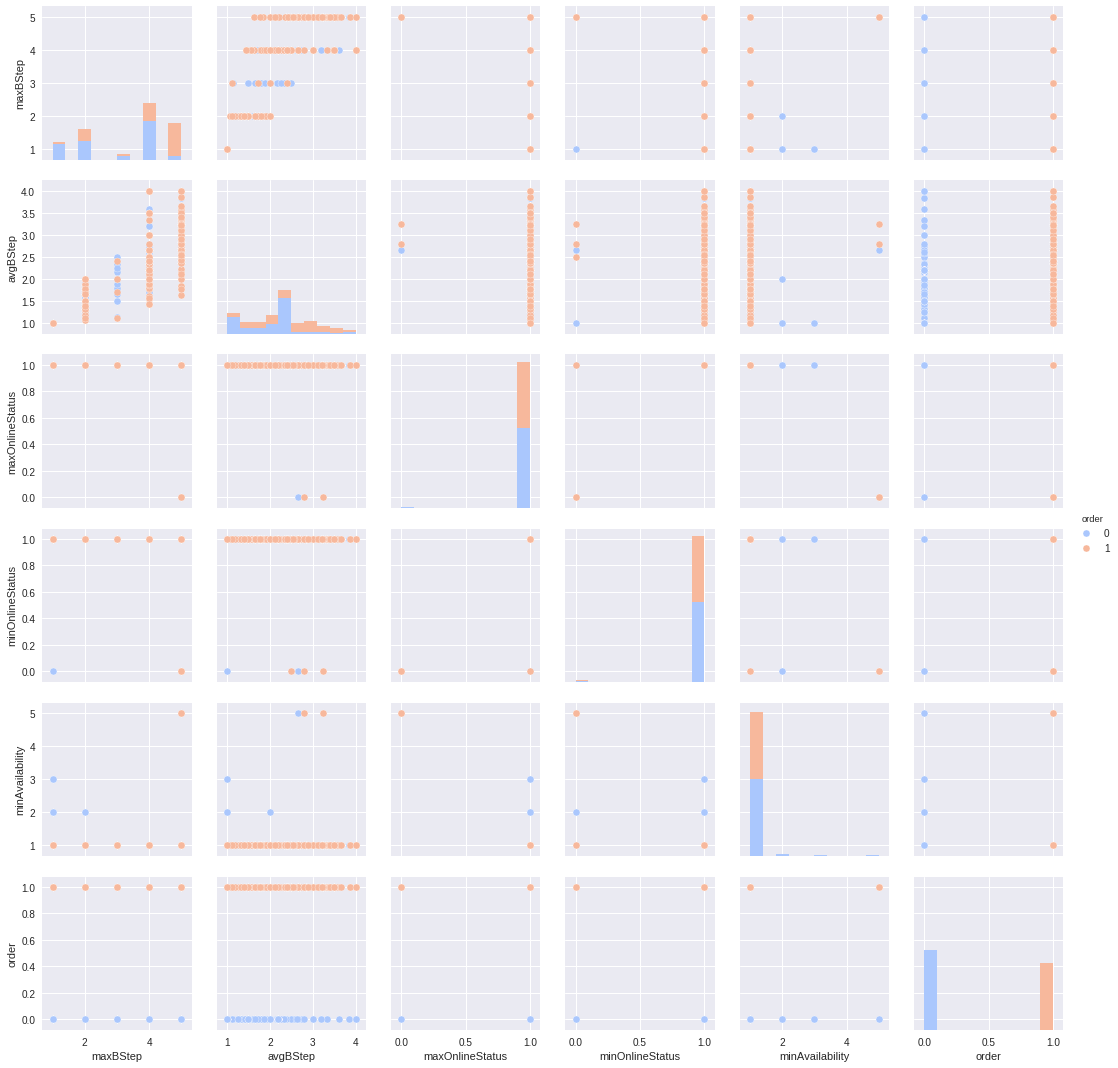

In [7]:
sns.pairplot(data_median_5_plot_m,hue='order',palette='coolwarm')

# Variablen standardisieren

### über alle Testdaten iterieren

In [0]:
from sklearn.preprocessing import StandardScaler
for key, value in data_knn.items():
    scaler_knn = StandardScaler()
    scaler_knn.fit(value['X_train'])
    scaled_features = scaler_knn.transform(value['X_train'])
    df_feat = pd.DataFrame(scaled_features,columns=value['X_train'].columns)

## Iterating over couple of n_neighbors to test error rate

iterieren mit verschieden k Werten

In [0]:
dataset = 'mean_10'

xtrain = data_knn[dataset]['X_train']
ytrain = data_knn[dataset]['y_train']
xtest = data_knn[dataset]['X_test']
ytest = data_knn[dataset]['y_test']

iteriere über alle Werte zwischen 1 und 80

In [0]:
error_rate = []


# Will take some time
for i in range(1,80):
    
    knn_loop = KNeighborsClassifier(n_neighbors=i)
    knn_loop.fit(xtrain_mean10_group,ytrain_mean10_group)
    prediciton_knn_i = knn_loop.predict(xtest_mean10_group)
    error_rate.append(np.mean(prediciton_knn_i != ytest_mean10_group))
    print(i, flush=True)

das Ergebniss grafisch darstellen

Text(0,0.5,'Error Rate')

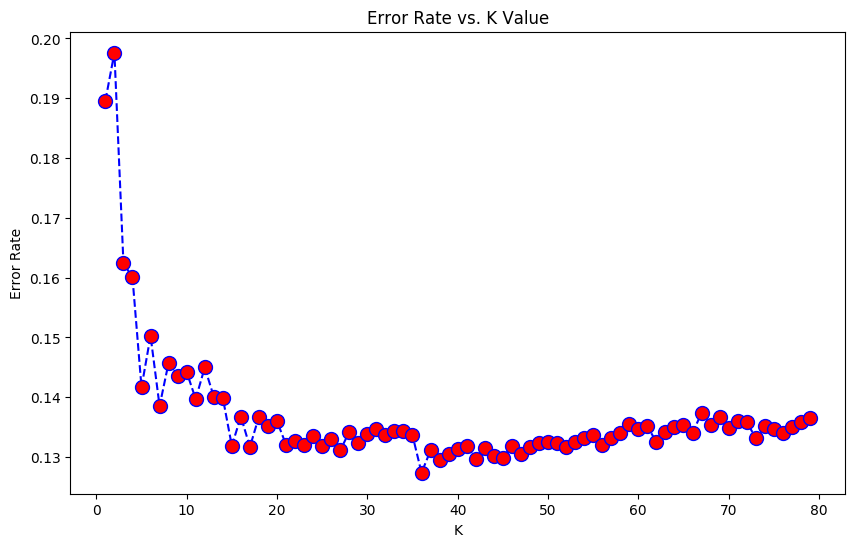

In [117]:
plt.figure(figsize=(10,6))
plt.plot(range(1,80),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

## KNN mit allen Testdateien tranieren und testen

mit kNN alle Datensatz Varianten trainieren und testen


In [0]:
from sklearn.neighbors import KNeighborsClassifier
models_knn = {}
for key, value in data_knn.items():
    knn_model = KNeighborsClassifier(n_neighbors=37)
    knn_model.fit(value['X_train'], value['y_train'])
    prediction_knn = knn_model.predict(value['X_test'])
    models_knn[key] = [knn_model,prediction_knn]

In [0]:
index_data_knn = []
column_data_knn = []
for key, value in models_knn.items():
    index_data_knn.append(key)
    column_data_knn.append(value[0].score(data_knn[key]['X_test'], data_knn[key]['y_test'])*100)


panda Dataframe mit Datensatzname und Performance des Datensatzes mit kNN

In [0]:
df_data_knn = pd.DataFrame(index=index_data_knn, data=column_data_knn)
df_data_knn.columns = ["performance"]
df_data_knn.sort_values(by="performance", ascending=True, inplace=True)

Ergebniss grafisch darstellen

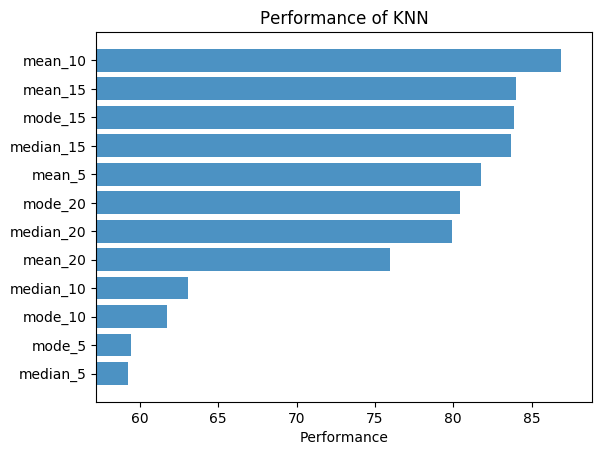

In [114]:
objects = df_data_knn.index.values
y_pos = np.arange(len(objects))
performance = df_data_knn.iloc[:,0]

plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance of KNN')

plt.show()

In [115]:
predictionScorekNN(data_knn['mean_10'])

86.79319115632948

## Wahrscheinlichkeit mit den am besten performenden Testdaten

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn_model_mean_10 = KNeighborsClassifier(n_neighbors=36)
knn_model_mean_10.fit(xtrain, ytrain)
prediction_knn_mean_10 = knn_model_mean_10.predict(xtrain)
performance_knn_mean_10 = knn_model_mean_10.score(xtest, ytest)*100

In [8]:
knn_model_mean_10.score(xtest, ytest)*100

87.26276658188222

Wahrscheinlichkeit ob 0 oder 1 ausrechnen lassen

In [0]:
predict_proba_knn_mean_10 = knn_model_mean_10.predict_proba(xtest)

loss und win arrays in panda Serien umwandeln

In [0]:
loss_ndarray = predict_proba_knn_mean_10[...,:1]
win_ndarray = predict_proba_knn_mean_10[...,1:]
my_list_test = map(lambda x: x[0], loss_ndarray)
loss_series = pd.Series(my_list_test)
my_list_test = map(lambda x: x[0], win_ndarray)
win_series = pd.Series(my_list_test)

panda Serien mit Session No kombinieren und nach Session No sortieren

In [0]:
knn_probability_df = pd.DataFrame({'buy_proba': win_series, 'not_buy_proba': loss_series},index=data_knn[dataset]['X_test'].index)
knn_probability_df = knn_probability_df.sort_index()

Ergebnis in csv speichern und runterladen

In [0]:

final_result = knn_probability_df_group.drop("not_buy_proba", axis=1)
final_result = final_result.rename(columns={"buy_proba": "Vorhersage"})
final_result_csv = final_result.to_csv("final_result", sep=';', encoding='utf-8')
final_result

In [0]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(final_result)

Gruppieren nach Session No (max/min hat keine Auswirkung, da alles Werte innerhalb einer Session gleich sind)

In [0]:
knn_probability_df_group = knn_probability_df.groupby(knn_probability_df.index).max()

Anteil derjenigen die eine Vorhersagewarhscheinlichkeit von 100% haben, ist dieser Anteil zu hoch, ist ein overfitting wahrscheinlich

In [14]:
print("Anteil an 100% Kauf Wahrscheinlichkeit")
round(knn_probability_df_group.loc[knn_probability_df_group['buy_proba'] == 1].size / knn_probability_df_group.size,4)

Anteil an 100% Kauf Wahrscheinlichkeit


0.0491

die Wahrscheinlichkeiten in 0.05 Abschnitte aufteilen und zählen

In [0]:
knn_probability_df_group = knn_probability_df.groupby(knn_probability_df.index).max()
bins_groupby = np.arange(0, 1.000001, 0.05)
knn_probability_df_group_bin = knn_probability_df_group.groupby(pd.cut(knn_probability_df_group['buy_proba'],bins_groupby)).count()

In [126]:
knn_probability_df_group_bin

,buy_proba,not_buy_proba
buy_proba,,
"(0.0, 0.05]",366,366
"(0.05, 0.1]",277,277
"(0.1, 0.15]",183,183
"(0.15, 0.2]",92,92
"(0.2, 0.25]",172,172
"(0.25, 0.3]",105,105
"(0.3, 0.35]",106,106
"(0.35, 0.4]",70,70
"(0.4, 0.45]",71,71


die obigen Tabelle grafisch darstellen

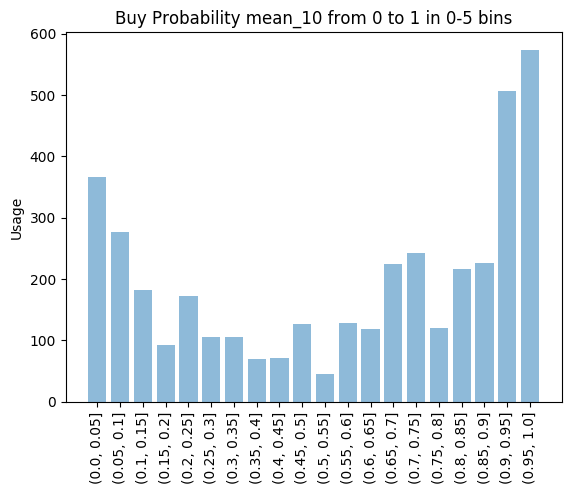

In [127]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = knn_probability_df_group_bin.index.values
y_pos = np.arange(len(objects))
performance = knn_probability_df_group_bin['buy_proba']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical')
plt.ylabel('Usage')
plt.title('Buy Probability mean_10 from 0 to 1 in 0-5 bins')
 
plt.show()

### Test with different models and mean_10

dies iteriert über viele versch. Modelle mit den Standartvariablen, mit Optimierung möglichweise mehr erreichbar

In [0]:
#sklearn
#from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#load package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from math import sqrt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [0]:
MLA = [
#     Ensemble Methods
   ensemble.AdaBoostClassifier(),
   ensemble.BaggingClassifier(),
   ensemble.ExtraTreesClassifier(),
   ensemble.GradientBoostingClassifier(), # best
   ensemble.RandomForestClassifier(),

    #Gaussian Processes (problems with this model)
   # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
   linear_model.LogisticRegressionCV(),
   linear_model.PassiveAggressiveClassifier(),
   linear_model. RidgeClassifierCV(),
   linear_model.SGDClassifier(),
   linear_model.Perceptron(),
    
    #Navies Bayes
   naive_bayes.BernoulliNB(),
   naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
   neighbors.KNeighborsClassifier(),
    
    #SVM
   svm.SVC(probability=True),
   svm.NuSVC(probability=True),
   svm.LinearSVC(),
    
    #Trees    
   tree.DecisionTreeClassifier(),
   tree.ExtraTreeClassifier(),
    
    ]

In [139]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(xtrain, ytrain).predict(xtest)
    fp, tp, th = roc_curve(ytest, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(xtrain, ytrain), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(xtest, ytest), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(ytest, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(ytest, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC
3,GradientBoostingClassifier,0.8701,0.8718,0.840261,0.886882,0.873089
4,RandomForestClassifier,0.9137,0.8709,0.861485,0.853333,0.869416
1,BaggingClassifier,0.9131,0.8693,0.859436,0.852043,0.867874
2,ExtraTreesClassifier,0.9165,0.8679,0.863116,0.843441,0.865906
0,AdaBoostClassifier,0.8622,0.8671,0.839242,0.875699,0.867857
12,KNeighborsClassifier,0.8793,0.8583,0.848802,0.837849,0.856649
16,DecisionTreeClassifier,0.9165,0.8578,0.858618,0.822796,0.854865
17,ExtraTreeClassifier,0.9165,0.8568,0.854157,0.826237,0.854253
5,LogisticRegressionCV,0.8159,0.8237,0.804014,0.809892,0.822570
15,LinearSVC,0.8105,0.8167,0.811770,0.777204,0.813405
